# Phytoplankton nutrient limitation
<div>
<img src="https://img.pagecloud.com/5v7MdnqDGKaeDDpybk5xJIM7kkQ=/552x0/filters:no_upscale()/scientific-illustrations-by-kristen/images/centric_diatom-a7dae-j39bc.png" width="300"/>
</div>

A centric diatom, another type of phytoplankton. Art credit: [Kristen Krumhardt](https://www.earthaliveillos.com/)

---

## Overview
In previous notebooks, we explored the distribution of different nutrients in the ocean. Here we explore how the growth of phytoplankton communities is limited by these nutrient distributions.

1. General setup
2. Subsetting
4. Processing data
5. Mapping nutrient limitation at the surface
6. Mapping biomass-weighted nutrient limitation in the top 100m
7. Making monthly climatology maps
   
TO DO: Add more narrative text, clean up comments, add references

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Dask Cookbook](https://projectpythia.org/dask-cookbook/README.html) | Helpful | |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray.html) | Helpful | |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |

- **Time to learn**: 30 min


---

## Imports

In [1]:
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import cartopy
import cartopy.crs as ccrs
import pop_tools
from dask.distributed import LocalCluster

## General setup (see intro notebooks for explanations)

### Connect to cluster

In [2]:
cluster = LocalCluster()
client = cluster.get_client()

/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33541 instead
  warnings.warn(


### Bring in POP grid utilities

In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
depths = ds_grid.z_t * 0.01

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    # Trick cartopy into doing the right thing:
    # it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    # Periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### Load the data

In [5]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/derecho/scratch/eromashkova/ocean-bgc-cookbook-data/cesm/'+case+'/ocn/proc/tseries/month_1'
coords = {'x':'TLONG','y':'TLAT'}
path

'/glade/derecho/scratch/eromashkova/ocean-bgc-cookbook-data/cesm/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/ocn/proc/tseries/month_1'

In [6]:
files = glob.glob(f'{path}/{case}.pop.h.*.201001-201912.nc')
ds=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True,
                       drop_variables=["transport_components", "transport_regions", 'moc_components'], decode_times=True)
ds

<xarray.Dataset> Size: 28GB
Dimensions:                         (nlat: 384, nlon: 320, time: 120, z_t: 60,
                                     z_t_150m: 15)
Coordinates:
    TLAT                            (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                            (time) object 960B 2010-01-16 12:00:00 .....
  * z_t                             (z_t) float32 240B 500.0 ... 5.375e+05
  * z_t_150m                        (z_t_150m) float32 60B 500.0 ... 1.45e+04
Dimensions without coordinates: nlat, nlon
Data variables: (12/45)
    FG_CO2                          (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    Fe                              (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    NO3                             (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    PO4                             (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    POC_FLUX_100m                   (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    SALT                            (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    ...                              ...
    sp_Fe_lim_Cweight_avg_100m      (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_Fe_lim_surf                  (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_N_lim_Cweight_avg_100m       (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_N_lim_surf                   (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_P_lim_Cweight_avg_100m       (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_P_lim_surf                   (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>

## Subsetting

In [7]:
variables =['sp_Fe_lim_Cweight_avg_100m','sp_P_lim_Cweight_avg_100m','sp_N_lim_Cweight_avg_100m',
             'diat_Fe_lim_Cweight_avg_100m', 'diat_P_lim_Cweight_avg_100m','diat_N_lim_Cweight_avg_100m',
             'diat_SiO3_lim_Cweight_avg_100m','diaz_P_lim_Cweight_avg_100m',
             'diaz_Fe_lim_Cweight_avg_100m','cocco_Fe_lim_Cweight_avg_100m','cocco_C_lim_Cweight_avg_100m','cocco_N_lim_Cweight_avg_100m',
             'cocco_P_lim_Cweight_avg_100m','sp_Fe_lim_surf','sp_P_lim_surf','sp_N_lim_surf',
             'diat_Fe_lim_surf', 'diat_P_lim_surf','diat_N_lim_surf','diat_SiO3_lim_surf',
             'diaz_P_lim_surf','cocco_Fe_lim_surf','cocco_C_lim_surf','cocco_N_lim_surf',
             'cocco_P_lim_surf','diaz_Fe_lim_surf']
keep_vars=['z_t','z_t_150m','dz','time_bound', 'time', 'TAREA','TLAT','TLONG'] + variables
ds = ds.drop_vars([v for v in ds.variables if v not in keep_vars])

## Processing

### Make a monthly climatology dataset

In [8]:
mon_ds = ds.copy()
mon_ds = ds.groupby('time.month').mean('time')

### Global mean in time

Pull in the functions we defined in the nutrients notebook...

In [9]:
def year_mean(ds):
    """
    Properly convert monthly data to annual means, taking into account month lengths.
    Source: https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
    """
    
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.year").sum().values, np.ones((len(ds.groupby("time.year")), )))

    # Calculate the weighted average
    return (ds * weights).groupby("time.year").sum(dim="time")
    

Take the long-term mean of our data set. We process monthly to annual with our custom function, then use xarray's built-in `.mean()` function to process from annual data to a single mean over time, since each year is the same length.

In [10]:
ds = year_mean(ds).mean("year")

## Mapping nutrient limitation at the surface
Add a paragraph here about how nutrient limitation works. See [Sarmiento and Gruber Chapter 4: Organic Matter Production](https://www.jstor.org/stable/j.ctt3fgxqx?turn_away=true).\
Most limiting nutrient - concatenate the limitation terms so that nutrient limitation terms are each along the `nutrient` dimension
- 0 = PO4
- 1 = Fe
- 2 = NO3 (only for sp and diat)
- 3 = Si (only for diat)
- 3 = C (only for cocco)

In [11]:
limarray_sp=xr.concat((ds.sp_P_lim_surf, ds.sp_Fe_lim_surf,ds.sp_N_lim_surf),dim='nutrient')
limarray_diat=xr.concat((ds.diat_P_lim_surf, ds.diat_Fe_lim_surf, ds.diat_N_lim_surf, ds.diat_SiO3_lim_surf),dim='nutrient')
limarray_diaz=xr.concat((ds.diaz_P_lim_surf, ds.diaz_Fe_lim_surf),dim='nutrient')
limarray_cocco=xr.concat((ds.cocco_P_lim_surf, ds.cocco_Fe_lim_surf, ds.cocco_N_lim_surf, ds.cocco_C_lim_surf),dim='nutrient')
                          
most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_cocco=limarray_cocco.argmin(dim='nutrient', skipna=False).squeeze()
mask = np.isnan(ds.sp_N_lim_surf.squeeze())

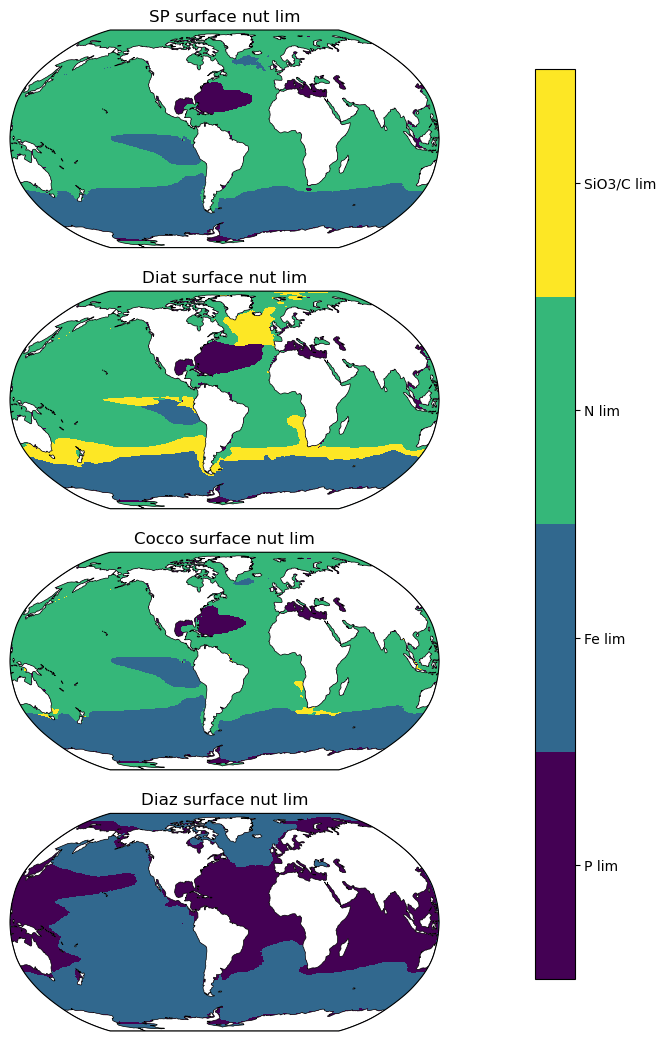

In [12]:
fig = plt.figure(figsize=(8,13))
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diat surface nut lim', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_diat.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('SP surface nut lim', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_sp.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Cocco surface nut lim', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_cocco.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diaz surface nut lim', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_diaz.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

## Mapping biomass-weighted nutrient limitations in the top 100m
What does biomass-weighted mean here? Explain further.

In [13]:
limarray_sp=xr.concat((ds.sp_P_lim_Cweight_avg_100m, ds.sp_Fe_lim_Cweight_avg_100m,ds.sp_N_lim_Cweight_avg_100m),dim='nutrient')
limarray_diat=xr.concat((ds.diat_P_lim_Cweight_avg_100m, ds.diat_Fe_lim_Cweight_avg_100m, ds.diat_N_lim_Cweight_avg_100m, ds.diat_SiO3_lim_Cweight_avg_100m),dim='nutrient')
limarray_diaz=xr.concat((ds.diaz_P_lim_Cweight_avg_100m, ds.diaz_Fe_lim_Cweight_avg_100m),dim='nutrient')
limarray_cocco=xr.concat((ds.cocco_P_lim_Cweight_avg_100m, ds.cocco_Fe_lim_Cweight_avg_100m, ds.cocco_N_lim_Cweight_avg_100m, ds.cocco_C_lim_Cweight_avg_100m),dim='nutrient')
                          
most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_cocco=limarray_cocco.argmin(dim='nutrient', skipna=False).squeeze()
mask = np.isnan(ds.sp_N_lim_surf.squeeze())

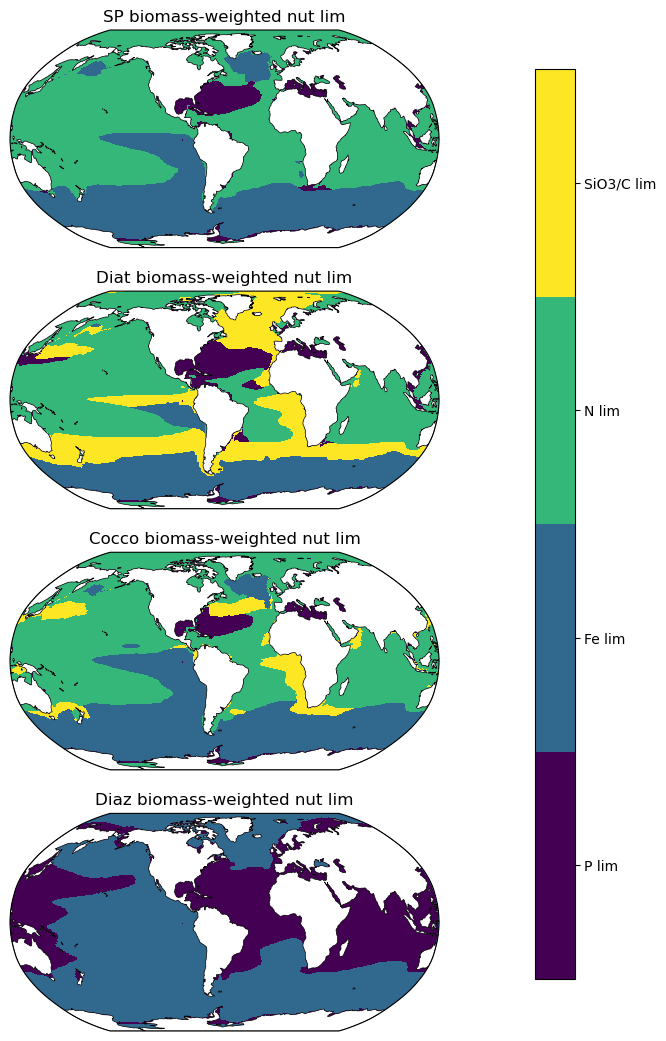

In [14]:
fig = plt.figure(figsize=(8,13))
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diat biomass-weighted nut lim', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_diat.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('SP biomass-weighted nut lim', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_sp.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Cocco biomass-weighted nut lim', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_cocco.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diaz biomass-weighted nut lim', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_diaz.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

## Making monthly climatology maps
Add some info about what a monthly climatology is and why making one is helpful.

In [15]:
limarray_sp=xr.concat((mon_ds.sp_P_lim_surf, mon_ds.sp_Fe_lim_surf,mon_ds.sp_N_lim_surf),dim='nutrient')
limarray_diat=xr.concat((mon_ds.diat_P_lim_surf, mon_ds.diat_Fe_lim_surf, mon_ds.diat_N_lim_surf, mon_ds.diat_SiO3_lim_surf),dim='nutrient')
limarray_diaz=xr.concat((mon_ds.diaz_P_lim_surf, mon_ds.diaz_Fe_lim_surf),dim='nutrient')
limarray_cocco=xr.concat((mon_ds.cocco_P_lim_surf, mon_ds.cocco_Fe_lim_surf, mon_ds.cocco_N_lim_surf, mon_ds.cocco_C_lim_surf),dim='nutrient')

most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False)
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False)
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False)
most_lim_cocco=limarray_cocco.argmin(dim='nutrient', skipna=False)
mask = np.isnan(ds.sp_N_lim_surf.squeeze())

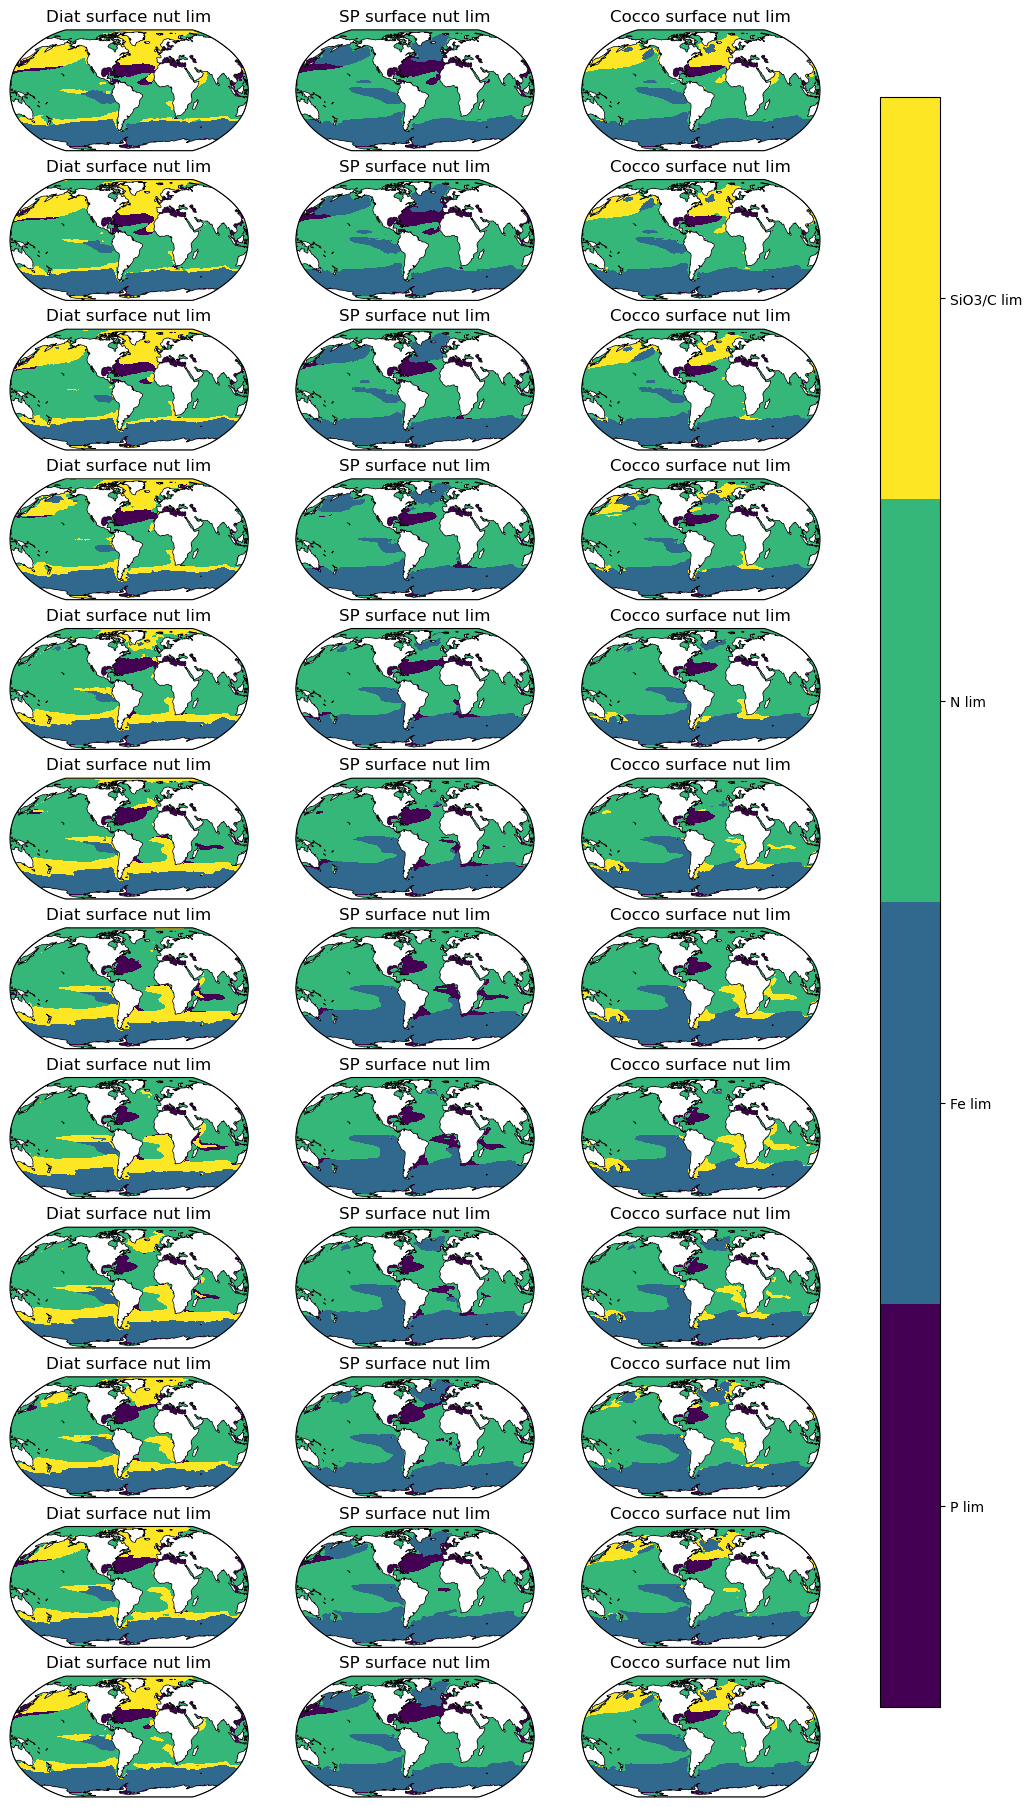

In [16]:
fig = plt.figure(figsize=(12,23))

for row in np.arange(1,13):
    ts=row-1
    
    plot = row*3 - 2
    
    #row 1 Jan
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Diat surface nut lim', fontsize=12)
    lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_diat.isel(month=ts).where(~mask))
    pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
    ax.add_feature(land)
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot = row*3 - 1
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('SP surface nut lim', fontsize=12)
    lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_sp.isel(month=ts).where(~mask))
    pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
    ax.add_feature(land)
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot = row*3
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Cocco surface nut lim', fontsize=12)
    lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_cocco.isel(month=ts).where(~mask))
    pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
    ax.add_feature(land)
    colorbar_specs = {'ticks' : np.arange(0,4,1)}

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

And close the Dask cluster we spun up at the beginning.

In [17]:
cluster.close()

---

## Summary
You've learned how to evaluate phytoplankton nutrient limitation.

## Resources and references
- [Sarmiento and Gruber Chapter 4: Organic Matter Production](https://doi.org/10.2307/j.ctt3fgxqx.7)